In [1]:
import torch
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
import torch.nn.functional as F
from utils.dataset import CocoDataset
from utils.plots import plot_rgb, reconstruct_lab, plot_losses, plot_model_pred
from utils.models import save_model, load_model
from utils.training import train_gan, load_losses
from utils.metrics import evaluate_model

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

- method of improvement: use other losses other than the gan one (wgan, regularized like in paper), try unet

## Data Import

In [3]:
height, width = 128, 128

transform = transforms.Compose([
    transforms.Resize((height, width)),
    transforms.ToTensor(),
])

In [4]:
dataset = CocoDataset(root="coco/images/train2014", transform=transform)

Found 82783 images.


## Data Prep
Consider for now only a small subset of the data (ho copiato baseline.ipynb)

In [5]:
torch.manual_seed(42)
test_size = int(0.2 * len(dataset))
train_size = len(dataset) - test_size
train, test = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train, batch_size=64, shuffle=True)
test_loader = DataLoader(test, batch_size=64, shuffle=False)
train_size = 5000
small_train, _ = random_split(train, [train_size, len(train) - train_size])
small_train_loader = DataLoader(small_train, batch_size=64, shuffle=True)
test_size = 1000
small_test, _ = random_split(test, [test_size, len(test) - test_size])
small_test_loader = DataLoader(small_test, batch_size=64, shuffle=False)

## GAN


In [6]:
# https://www.sciencedirect.com/science/article/pii/S1319157822000519
# this paper shows that adding l1 regularization to gan losses improves the results

# https://github.com/soumith/ganhacks#6-use-soft-and-noisy-labels

In [6]:
# to improve on the results of the cnn we try to use a fully convolutional network
# first we do encoder decoder only and then unet (same as before)
# idea similar to paper Image-to-Image Translation with Conditional Adversarial Networks

class EncoderDecoderGenerator(nn.Module):
    """
    Encoder-decoder generator for image colorization.

    This generator takes a grayscale image as input and outputs the colorized version.

    Attributes:
        encoder (nn.Sequential): Sequential container of encoder convolutional layers, batch normalization, dropout, and leaky ReLU activations.
        decoder (nn.Sequential): Sequential container of decoder convolutional layers, upsampling, batch normalization, and leaky ReLU activations.
        sigmoid (nn.Sigmoid): Sigmoid activation function for the output layer.

    Methods:
        forward(x: torch.Tensor) -> torch.Tensor:
            Defines the forward pass of the generator.
    """

    def __init__(self):
        """
        Initializes the EncoderDecoderGenerator.
        """
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 128, kernel_size=4, stride=2, padding=1),  # image size: 128x128
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 64x64
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # 32x32
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1),  # 16x16
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1),  # 8x8
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        ) 

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1),  # 16x16
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1),  # 32x32
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # 64x64
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 128x128
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(128, 2, kernel_size=4, stride=2, padding=1),  # 256x256
        )

        self.sigmoid = nn.Sigmoid()

    def forward(self, x: torch.Tensor):
        """
        Defines the forward pass of the generator.

        Args:
            x (torch.Tensor): Input grayscale image tensor of shape (batch_size, 1, height, width).

        Returns:
            torch.Tensor: Output colorized image tensor of shape (batch_size, 2, height, width).
        """
        x = self.encoder(x)
        x = self.decoder(x)
        return self.sigmoid(x)

class DiscriminatorCNN(nn.Module):
    """
    Discriminator network for image colorization.
    This discriminator takes a colorized image as input and outputs a scalar value representing the probability that the input image is real or generated.

    Attributes:
        conv (nn.Sequential): Sequential container of convolutional layers, batch normalization, and leaky ReLU activations.
        sigmoid (nn.Sigmoid): Sigmoid in final layer.

    Methods:
        forward(x: torch.Tensor) -> torch.Tensor: Defines the forward pass of the discriminator.
    """

    def __init__(self):
        """
        Initializes the Discriminator.
        """
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # 128x128
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 64x64
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 32x32
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # 16x16
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 256, kernel_size=4, stride=2, padding=1),  # 8x8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 128, kernel_size=4, stride=2, padding=1),  # 4x4
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 1, kernel_size=4, stride=1, padding=0),  # 1x1
        )
        
        self.sigmoid = nn.Sigmoid()

    def forward(self, x: torch.Tensor):
        """
        Defines the forward pass of the discriminator.

        Args:
            x (torch.Tensor): Input colorized image tensor of shape (batch_size, 3, height, width).

        Returns:
            torch.Tensor: Output scalar value representing the probability that the input image is real or generated, of shape (batch_size, 1).
        """
        x = self.conv(x)
        return self.sigmoid(x)

In [7]:
# class UNetGenerator(nn.Module): # same as generator but with skip connections
#     """
#     U-Net generator for image colorization.

#     This generator takes a grayscale image as input and outputs the colorized version, utilizing skip connections between the encoder and decoder.

#     Attributes:
#         encoder (nn.ModuleList): List of encoder layers.
#         decoder (nn.ModuleList): List of decoder layers.
#         final (nn.ConvTranspose2d): Final convolutional layer.
#         sigmoid (nn.Sigmoid): Sigmoid activation function for the output layer.

#     Methods:
#         forward(x: torch.Tensor) -> torch.Tensor:
#             Defines the forward pass of the generator.
#     """

#     def __init__(self):
#         """
#         Initializes the UNetGenerator.
#         """
#         super().__init__()

#         # Encoder
#         self.encoder = nn.ModuleList([
#             nn.Sequential(
#                 nn.Conv2d(1, 128, kernel_size=4, stride=2, padding=1),  # image size: 128x128
#                 nn.LeakyReLU(0.2, inplace=True)
#             ),
#             nn.Sequential(
#                 nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 64x64
#                 nn.BatchNorm2d(256),
#                 nn.LeakyReLU(0.2, inplace=True)
#             ),
#             nn.Sequential(
#                 nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # 32x32
#                 nn.BatchNorm2d(512),
#                 nn.LeakyReLU(0.2, inplace=True)
#             ),
#             nn.Sequential(
#                 nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1),  # 16x16
#                 nn.BatchNorm2d(512),
#                 nn.LeakyReLU(0.2, inplace=True)
#             ),
#             nn.Sequential(
#                 nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1),  # 8x8
#                 nn.BatchNorm2d(512),
#                 nn.LeakyReLU(0.2, inplace=True)
#             ),
#         ])

#         # Decoder
#         self.decoder = nn.ModuleList([
#             nn.Sequential(
#                 nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1),  # 16x16
#                 nn.BatchNorm2d(512),
#                 nn.LeakyReLU(0.2, inplace=True)
#             ),
#             nn.Sequential(
#                 nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1),  # 32x32
#                 nn.BatchNorm2d(512),
#                 nn.LeakyReLU(0.2, inplace=True)
#             ),
#             nn.Sequential(
#                 nn.ConvTranspose2d(1024, 256, kernel_size=4, stride=2, padding=1),  # 64x64
#                 nn.BatchNorm2d(256),
#                 nn.LeakyReLU(0.2, inplace=True)
#             ),
#             nn.Sequential(
#                 nn.ConvTranspose2d(512, 128, kernel_size=4, stride=2, padding=1),  # 128x128
#                 nn.BatchNorm2d(128),
#                 nn.LeakyReLU(0.2, inplace=True)
#             ),
#         ])

#         self.final = nn.ConvTranspose2d(256, 2, kernel_size=4, stride=2, padding=1)  # 256x256
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x: torch.Tensor):
#         """
#         Defines the forward pass of the generator.

#         Args:
#             x (torch.Tensor): Input grayscale image tensor of shape (batch_size, 1, height, width).

#         Returns:
#             torch.Tensor: Output colorized image tensor of shape (batch_size, 2, height, width).
#         """
#         # Encoder forward pass with saving outputs for skip connections
#         skips = []
#         for layer in self.encoder:
#             x = layer(x)
#             skips.append(x)
        
#         skips = skips[::-1]

#         # Decoder forward pass with skip connections
#         for i, layer in enumerate(self.decoder):
#             x = torch.cat((x, skips[i]), 1)
#             x = layer(x)

#         # Final layer
#         x = torch.cat((x, skips[-1]), 1)
#         x = self.final(x)

#         return self.sigmoid(x)


# # we use a patchgan as a discriminator
# # it is just a discriminator that looks at patches, rather than at pixels.
# # so instead of outputting a single value, patchgan outptus a map where each
# # point refers to probability a patch in the image. 
# # this is of course an improvement over pixel wise methods

class PatchGANDiscriminator(nn.Module):
    """
    PatchGAN discriminator for image colorization.

    This discriminator classifies each patch of the input image as real or fake.

    Attributes:
        conv (nn.Sequential): Sequential container of convolutional layers, batch normalization, and leaky ReLU activations.

    Methods:
        forward(x: torch.Tensor) -> torch.Tensor:
            Defines the forward pass of the discriminator.
    """

    def __init__(self):
        """
        Initializes the PatchGANDiscriminator.
        """
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # image size: 128x128
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), # 64x64
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # 32x32
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1), # 16x16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 1, kernel_size=3, stride=1, padding="same") # 16x16
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x: torch.Tensor):
        """
        Defines the forward pass of the discriminator.

        Args:
            x (torch.Tensor): Input image tensor of shape (batch_size, 3, height, width).

        Returns:
            torch.Tensor: Output tensor representing the probability of the input being real. Shape: (batch_size, 1, height, width).
        """
        x = self.conv(x)
        return self.sigmoid(x)

we observed many times the loss of discriminator going to zero, and then that of the generator going up indefinetly (with encoder decoder, both gan loss). unet it's too slow for our computational resources so we avoid it. we try with regularizer on encoder decoder architecture and use cnn discriminator.

we found that discriminators (both cnn and patch) tended to go to low losses very quickly (3/4 epochs) making it harder for the generator to learn. to reduce the overconfidence of the discriminator we apply one-sided label smoothing, also to account for the fact that colors may vary a bit, in which we smooth positive values.

It is important to not smooth the labels for the fake samples https://arxiv.org/pdf/1701.00160

we use adam for generator and sgd for discriminator.

In [9]:
torch.manual_seed(42)

generator_encdec = EncoderDecoderGenerator().to(device)
generator_encdec_opt = optim.Adam(generator_encdec.parameters(), lr=0.0002, betas=(0.5, 0.999))

discriminator_cnn = DiscriminatorCNN().to(device)
discriminator_cnn_opt = optim.SGD(discriminator_cnn.parameters(), lr=0.0002, momentum=0.9, nesterov=True)

criterion = nn.BCELoss()

In [10]:
torch.manual_seed(42)
d_losses, g_losses = train_gan(100, discriminator_cnn, generator_encdec, discriminator_cnn_opt, generator_encdec_opt,
                               criterion, small_train_loader, device, l1_lambda=2, label_smoothing=True,
                               save_losses=True, save_checkpoints=True, file_name="gan_encdec")

Epoch 33/100: 100%|██████████| 79/79 [02:56<00:00,  2.23s/it, d_loss=0.134, g_loss=8.02]


Model saved to models\gan_encdec_33.pth successfully!


Epoch 66/100: 100%|██████████| 79/79 [02:56<00:00,  2.23s/it, d_loss=0.134, g_loss=8.69]


Model saved to models\gan_encdec_66.pth successfully!


Epoch 100/100: 100%|██████████| 79/79 [02:56<00:00,  2.23s/it, d_loss=0.134, g_loss=9.09]

Model saved to models\gan_encdec_100.pth successfully!
Losses saved to losses\gan_encdec_losses.txt
Finished Training


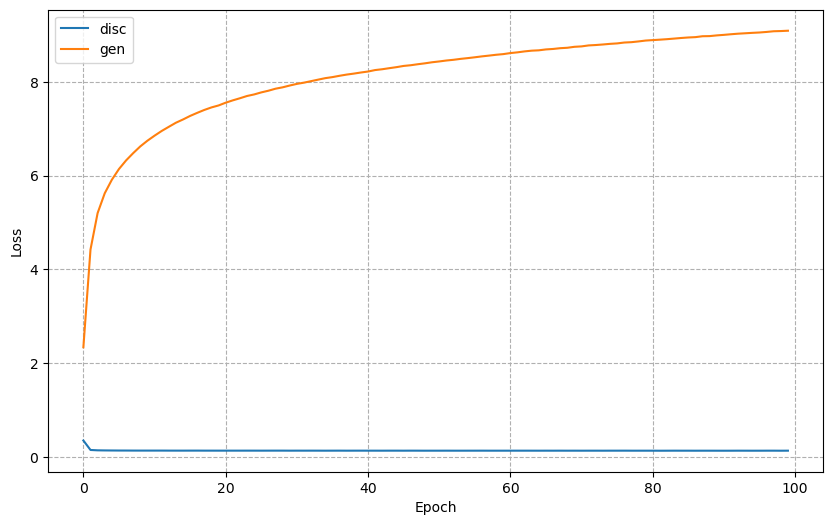

In [11]:
plot_losses(d_losses, g_losses, "disc", "gen")

c:\Users\sandr\Desktop\ML\project\image-colorization\utils\plots.py:129: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2538 negative Z values that have been clipped to zero
  rgb_image = lab2rgb(lab_image_reconstructed)


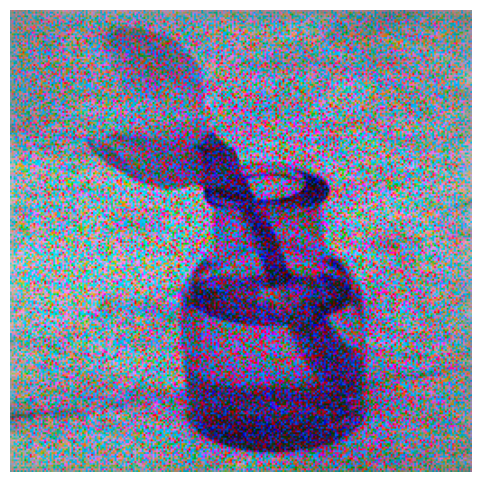

In [12]:
plot_model_pred(dataset[533][1], generator_encdec)

training has failed and disc loss decreases fast and then stays the same for all the epochs. there could be several factors. in general mode collapse may have happened, as we get similar patterns for pretty much every image. this can also explain why the gen loss keeps going up. we could change it using a patchgan discriminator and see if it's an architecture problem or not.

In [14]:
torch.manual_seed(42)
avg_mse, std_mse, avg_psnr, std_psnr, avg_ssim, std_ssim, fid = evaluate_model(generator_encdec, small_test_loader, device)
print(f"Average MSE: {avg_mse:.4f}")
print(f"Average PSNR: {avg_psnr:.4f}")
print(f"Average SSIM: {avg_ssim:.4f}")
print(f"FID: {fid:.4f}")

Average MSE: 0.0771
Average PSNR: 22.2564
Average SSIM: 0.0130
FID: 382.1754


In [15]:
torch.manual_seed(42)
discriminator_patch = PatchGANDiscriminator().to(device)
discriminator_patch_opt = optim.SGD(discriminator_patch.parameters(), lr=0.0002, momentum=0.9, nesterov=True)
generator_encdec = EncoderDecoderGenerator().to(device)
generator_encdec_opt = optim.Adam(generator_encdec.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCELoss()

In [16]:
torch.manual_seed(42)
d_losses_2, g_losses_2 = train_gan(100, discriminator_patch, generator_encdec, discriminator_patch_opt, generator_encdec_opt,
                                   criterion, small_train_loader, device, l1_lambda=2, label_smoothing=True,
                                   save_losses=True, save_checkpoints=True, file_name="gan_encdec2")

Epoch 33/100: 100%|██████████| 79/79 [03:23<00:00,  2.57s/it, d_loss=0.149, g_loss=4.48]


Model saved to models\gan_encdec2_33.pth successfully!


Epoch 41/100:   8%|▊         | 6/79 [00:19<04:01,  3.30s/it, d_loss=0.144, g_loss=4.85]


KeyboardInterrupt: 

In [ ]:
plot_losses(d_losses_2, g_losses_2, "disc", "gen")

In [ ]:
plot_model_pred(dataset[533][1], generator_encdec)

In [ ]:
torch.manual_seed(42)
avg_mse, std_mse, avg_psnr, std_psnr, avg_ssim, std_ssim, fid = evaluate_model(generator_encdec, small_test_loader, device)
print(f"Average MSE, STD: {avg_mse:.4f}, {std_mse:.4f}")
print(f"Average PSNR, STD: {avg_psnr:.4f}, {std_psnr:.4f}")
print(f"Average SSIM, STD: {avg_ssim:.4f}, {std_ssim:.4f}")
print(f"FID: {fid:.4f}")

for now training with this encoder decoder doesn't work well, so possibly the architecture of the encdec is not good enough. 
we'll change enc-dec architecture, avoiding going thorugh a too low bottleneck and adding more layers.

NOTE--> in the above models i tried 256, 256 but now i try smaller for memory constraints in my pc.

In [9]:
class GeneratorCNN(nn.Module):
    """
    A deep Convolutional Neural Network (CNN) generator model for image colorization.

    This model consists of convolutional layers, batch normalization, and Leaky ReLU
    activations, followed by fully connected layers to produce the final colorized image.

    Attributes:
        height (int): Height of the input image.
        width (int): Width of the input image.
        conv (nn.Sequential): Sequential container of convolutional layers, batch normalization,
                              and Leaky ReLU activations.
        flatten (nn.Flatten): Layer to flatten the output of the convolutional layers.
        fc1 (nn.Linear): First fully connected layer that outputs the final prediction.
        sigmoid (nn.Sigmoid): Sigmoid activation function for the output layer.

    Methods:
        forward(x: torch.Tensor) -> torch.Tensor:
            Defines the forward pass of the model.
    """

    def __init__(self):
        """
        Initializes the CNN model with specified height and width of the input image.

        Args:
            height (int): Height of the input image.
            width (int): Width of the input image.
        """
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 128, kernel_size=3, stride=1, padding=1),  # keep same image size
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1), # 128x128
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # keep same image size
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 256, kernel_size=4, stride=2, padding=1), # 64x64
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),  # keep same image size
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1), # 32x32 --> final bottleneck
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1),  # 64x64
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=1, padding=1),  # keep same image size
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, padding=1),  # 128x128
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=1),  # keep same image size
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1),  # 256x256
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=1, padding=1),  # keep same image size
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.final_conv = nn.Conv2d(128, 2, kernel_size=3, stride=1, padding=1)
        self.sigmoid = nn.Sigmoid()
            
            # nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),  # keep same image size
            # nn.BatchNorm2d(512),
            # nn.LeakyReLU(0.2, inplace=True),
            
            # nn.Conv2d(512, 128, kernel_size=3, stride=1, padding=1),  # keep same image size
            # nn.BatchNorm2d(128),
            # nn.LeakyReLU(0.2, inplace=True),
            
            # nn.Conv2d(128, 32, kernel_size=3, stride=1, padding=1),  # keep same image size
            # nn.LeakyReLU(0.2, inplace=True),
            # nn.BatchNorm2d(32),
            
            # nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
            
            # nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),  # 32x32
            # nn.BatchNorm2d(512),
            # nn.LeakyReLU(0.2, inplace=True),
            # nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),  # 16x16
            # nn.BatchNorm2d(512),
            # nn.LeakyReLU(0.2, inplace=True),
            # nn.Conv2d(512, 128, kernel_size=3, stride=1, padding=1),  # 8x8
            # nn.BatchNorm2d(128),
            # nn.LeakyReLU(0.2, inplace=True),
            # nn.Conv2d(128, 64, kernel_size=4, stride=2, padding=1),  # 4x4
            # nn.BatchNorm2d(64),
            # nn.LeakyReLU(0.2, inplace=True),
        # )
        # self.flatten = nn.Flatten()
        # self.fc1 = nn.Linear(1024, 2 * self.height * self.width)  # adjust accordingly
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x: torch.Tensor):
        """
        Defines the forward pass of the model.

        Args:
            x (torch.Tensor): Input image tensor of shape (batch_size, 1, height, width).

        Returns:
            torch.Tensor: Output tensor reshaped to (batch_size, 2, height, width).
        """
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.final_conv(x)
        # x = self.flatten(x)
        # x = self.fc1(x)
        # x = 
        # x = x.view(-1, 2, self.height, self.width)
        return self.sigmoid(x)
    
    
#  IN THIS MODEL I REMOVED A LAYER SINCE I AM USING 128X128 IMAGES AND NOT 256X256
# LATER NEEDS TO BE ADJUSTED.
class DiscriminatorCNN(nn.Module):
    """
    Discriminator network for image colorization.
    This discriminator takes a colorized image as input and outputs a scalar value representing the probability that the input image is real or generated.

    Attributes:
        conv (nn.Sequential): Sequential container of convolutional layers, batch normalization, and leaky ReLU activations.
        sigmoid (nn.Sigmoid): Sigmoid in final layer.

    Methods:
        forward(x: torch.Tensor) -> torch.Tensor: Defines the forward pass of the discriminator.
    """

    def __init__(self):
        """
        Initializes the Discriminator.
        """
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # 128x128
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 64x64
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 32x32
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # 16x16
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 256, kernel_size=4, stride=2, padding=1),  # 8x8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, kernel_size=4, stride=2, padding=1),  # 4x4 
            # nn.BatchNorm2d(128),
            # nn.LeakyReLU(0.2, inplace=True),
            # nn.Conv2d(128, 1, kernel_size=4, stride=1, padding=0),  # 1x1
        )
        
        self.sigmoid = nn.Sigmoid()

    def forward(self, x: torch.Tensor):
        """
        Defines the forward pass of the discriminator.

        Args:
            x (torch.Tensor): Input colorized image tensor of shape (batch_size, 3, height, width).

        Returns:
            torch.Tensor: Output scalar value representing the probability that the input image is real or generated, of shape (batch_size, 1).
        """
        x = self.conv(x)
        return self.sigmoid(x)

remember to rename this from generator cnn to encoder decoder as above.

In [27]:
torch.manual_seed(42)

generator_cnn = GeneratorCNN().to(device)
generator_cnn_opt = optim.Adam(generator_cnn.parameters(), lr=0.0002, betas=(0.5, 0.999))

discriminator_cnn = DiscriminatorCNN().to(device)
discriminator_cnn_opt = optim.SGD(discriminator_cnn.parameters(), lr=0.0002, momentum=0.9, nesterov=True)

criterion = nn.BCELoss()

In [28]:
torch.manual_seed(42)
d_losses_3, g_losses_3 = train_gan(100, discriminator_cnn, generator_cnn, discriminator_cnn_opt, generator_cnn_opt,
                                   criterion, small_train_loader, device, l1_lambda=2, label_smoothing=True,
                                   save_losses=True, save_checkpoints=True, file_name="gan_cnn")

Epoch 33/100: 100%|██████████| 79/79 [02:49<00:00,  2.14s/it, d_loss=0.136, g_loss=6.76]


Model saved to models\gan_cnn_33.pth successfully!


Epoch 45/100:  90%|████████▉ | 71/79 [02:35<00:17,  2.19s/it, d_loss=0.135, g_loss=7.23]


KeyboardInterrupt: 

In [ ]:
plot_losses(d_losses_3, g_losses_3, "disc", "gen")
plot_model_pred(dataset[533][1], generator_cnn)

In [ ]:
torch.manual_seed(42)
avg_mse, std_mse, avg_psnr, std_psnr, avg_ssim, std_ssim, fid = evaluate_model(generator_cnn, small_test_loader, device)
print(f"Average MSE, STD: {avg_mse:.4f}, {std_mse:.4f}")
print(f"Average PSNR, STD: {avg_psnr:.4f}, {std_psnr:.4f}")
print(f"Average SSIM, STD: {avg_ssim:.4f}, {std_ssim:.4f}")
print(f"FID: {fid:.4f}")

RuntimeError: running_mean should contain 128 elements not 16

In [29]:
torch.manual_seed(42)

generator_cnn = GeneratorCNN().to(device)
generator_cnn_opt = optim.Adam(generator_cnn.parameters(), lr=0.0002, betas=(0.5, 0.999))

discriminator_patch = PatchGANDiscriminator().to(device)
discriminator_patch_opt = optim.SGD(discriminator_patch.parameters(), lr=0.0002, momentum=0.9, nesterov=True)

criterion = nn.BCELoss()

In [30]:
torch.manual_seed(42)
d_losses_4, g_losses_4 = train_gan(100, discriminator_patch, generator_cnn, discriminator_patch_opt, generator_cnn_opt,
                                   criterion, small_train_loader, device, l1_lambda=2, label_smoothing=True,
                                   save_losses=True, save_checkpoints=True, file_name="gan_cnn_patch")
# run out of memory at epoch 40 because i'm stupid

Epoch 33/100: 100%|██████████| 79/79 [02:06<00:00,  1.60s/it, d_loss=0.148, g_loss=4.22]


Model saved to models\gan_cnn_patch_33.pth successfully!


Epoch 40/100:  51%|█████     | 40/79 [01:10<01:08,  1.76s/it, d_loss=0.143, g_loss=4.6] 


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [18]:
prova = load_model(GeneratorCNN(), "models/gan_cnn_patch_33.pth").to(device)

GeneratorCNN model loaded successfully!


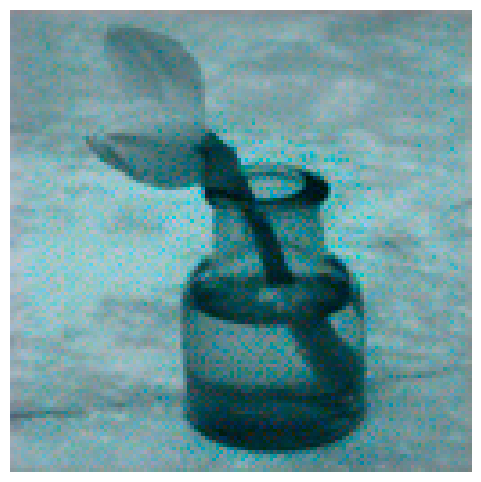

In [19]:
plot_model_pred(dataset[533][1], prova)

In [ ]:
d_losses_4, g_losses_4 = train_gan(60, discriminator_patch, generator_cnn, discriminator_patch_opt, generator_cnn_opt,
                                   criterion, small_train_loader, device, l1_lambda=2, label_smoothing=True,
                                   save_losses=True, save_checkpoints=True, file_name="gan_cnn_patch")

In [ ]:
plot_losses(d_losses_4, g_losses_4, "disc", "gen")
plot_model_pred(dataset[533][1], generator_cnn)

In [ ]:
torch.manual_seed(42)
avg_mse, std_mse, avg_psnr, std_psnr, avg_ssim, std_ssim, fid = evaluate_model(generator_cnn, small_test_loader, device)
print(f"Average MSE, STD: {avg_mse:.4f}, {std_mse:.4f}")
print(f"Average PSNR, STD: {avg_psnr:.4f}, {std_psnr:.4f}")
print(f"Average SSIM, STD: {avg_ssim:.4f}, {std_ssim:.4f}")
print(f"FID: {fid:.4f}")

increase lambda (as seen in paper)

In [12]:
torch.manual_seed(42)

generator_cnn = GeneratorCNN().to(device)
generator_cnn_opt = optim.Adam(generator_cnn.parameters(), lr=0.0002, betas=(0.5, 0.999))

discriminator_patch = PatchGANDiscriminator().to(device)
discriminator_patch_opt = optim.SGD(discriminator_patch.parameters(), lr=0.0002, momentum=0.9, nesterov=True)

criterion = nn.BCELoss()

In [13]:
torch.manual_seed(42)
d_losses_5, g_losses_5 = train_gan(100, discriminator_patch, generator_cnn, discriminator_patch_opt, generator_cnn_opt,
                                   criterion, small_train_loader, device, l1_lambda=5, label_smoothing=True,
                                   save_losses=True, save_checkpoints=True, file_name="gan_cnn_patch_lambda5")

Epoch 33/100: 100%|██████████| 79/79 [03:01<00:00,  2.30s/it, d_loss=0.0783, g_loss=4.04]


Model saved to models\gan_cnn_patch_lambda5_33.pth successfully!


Epoch 66/100: 100%|██████████| 79/79 [03:10<00:00,  2.41s/it, d_loss=0.0634, g_loss=5.37]


Model saved to models\gan_cnn_patch_lambda5_66.pth successfully!


Epoch 100/100: 100%|██████████| 79/79 [03:01<00:00,  2.30s/it, d_loss=0.0613, g_loss=6]   

Model saved to models\gan_cnn_patch_lambda5_100.pth successfully!
Losses saved to losses\gan_cnn_patch_lambda5_losses.txt
Finished Training


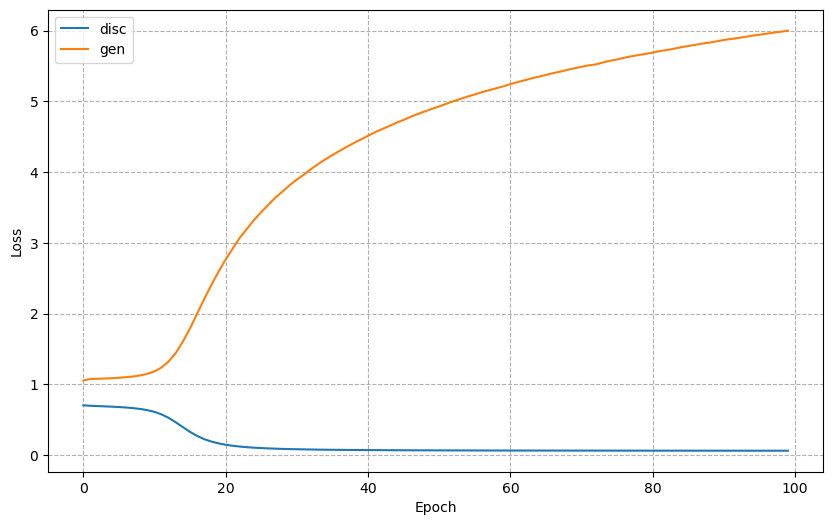

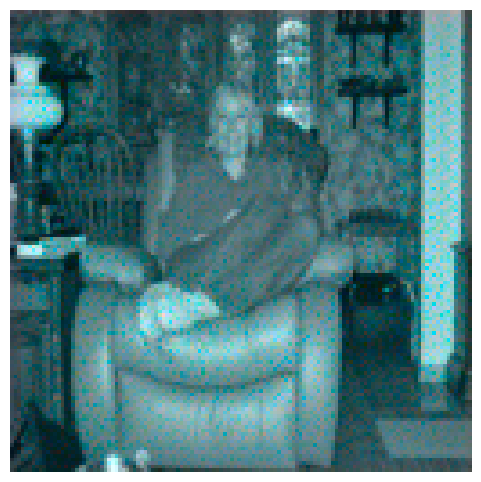

In [21]:
plot_losses(d_losses_5, g_losses_5, "disc", "gen")
plot_model_pred(dataset[7643][1], generator_cnn)

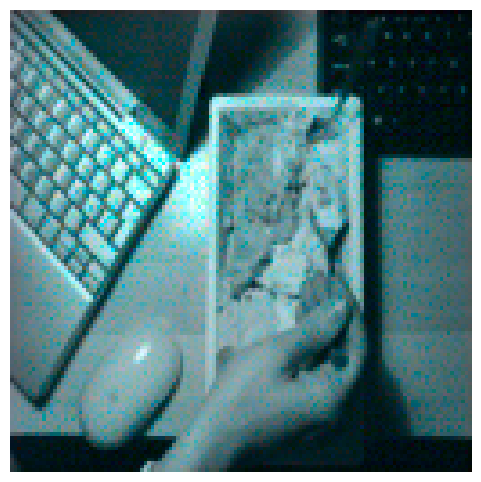

In [22]:
plot_model_pred(dataset[743][1], generator_cnn)

In [ ]:
torch.manual_seed(42)
avg_mse, std_mse, avg_psnr, std_psnr, avg_ssim, std_ssim, fid = evaluate_model(generator_cnn, small_test_loader, device)
print(f"Average MSE, STD: {avg_mse:.4f}, {std_mse:.4f}")
print(f"Average PSNR, STD: {avg_psnr:.4f}, {std_psnr:.4f}")
print(f"Average SSIM, STD: {avg_ssim:.4f}, {std_ssim:.4f}")
print(f"FID: {fid:.4f}")

in most models we find the case of mode collapse (i.e. same output) which explains why values of gen loss go up forever.

In [ ]:
class DiscriminatorCNN(nn.Module):
    """
    Discriminator network for image colorization.
    This discriminator takes a colorized image as input and outputs a scalar value representing the probability that the input image is real or generated.

    Attributes:
        conv (nn.Sequential): Sequential container of convolutional layers, batch normalization, and leaky ReLU activations.
        sigmoid (nn.Sigmoid): Sigmoid in final layer.

    Methods:
        forward(x: torch.Tensor) -> torch.Tensor: Defines the forward pass of the discriminator.
    """

    def __init__(self):
        """
        Initializes the Discriminator.
        """
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # 128x128
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 64x64
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 32x32
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # 16x16
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 256, kernel_size=4, stride=2, padding=1),  # 8x8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, kernel_size=4, stride=2, padding=1),  # 4x4 
            # nn.BatchNorm2d(128),
            # nn.LeakyReLU(0.2, inplace=True),
            # nn.Conv2d(128, 1, kernel_size=4, stride=1, padding=0),  # 1x1
        )
        
        self.sigmoid = nn.Sigmoid()

    def forward(self, x: torch.Tensor):
        """
        Defines the forward pass of the discriminator.

        Args:
            x (torch.Tensor): Input colorized image tensor of shape (batch_size, 3, height, width).

        Returns:
            torch.Tensor: Output scalar value representing the probability that the input image is real or generated, of shape (batch_size, 1).
        """
 
        return self.conv(x)

OLD FROM NOW ON.

In [8]:
# # we don't want to train the discriminator more than the the generator,
# # like they do in the original paper. this is because if the discrimintaor
# # gets good at recognizing true/colorized images, it will only do that by measuring the pixels.
# # instead we deem an image to be colorized well even if the color is not the same as the original.
# # for example, if in an image the t-shirt color is blue and the model is able to colorize it properly
# # (i.e. uniformly, shadows, etc.) but in red, we (humans) still consider that
# # colorized image good, but the discriminator does not, so then the generator learns in a bad way.
# # a way to improve this could be having a patch gan discriminator!

# # in general it's important to note that the loss values alone do not provide a complete picture
# # of the generator's performance. It's essential to visually inspect the generated colorized
# # images to assess their quality and realism.



In [9]:
# it is expected for the discriminator's loss to decrease and the generator's loss
# to increase during the initial stages of training in a GAN setup. This behavior
# is commonly observed and is a part of the adversarial training process.
# In the beginning, both the generator and discriminator are relatively untrained,
# and their outputs are essentially random noise. As a result, their losses are
# typically high but close to each other. However, as training progresses, the
# discriminator starts to learn faster and becomes better at distinguishing real
# samples from the generator's fake samples. At this point, the discriminator's
# loss decreases as it becomes more accurate at identifying real and fake samples.
# Conversely, the generator's loss increases because its samples are now easily
# recognized as fake by the improving discriminator. This creates a gap between
# the generator's and discriminator's losses. The generator then has to adapt and
# learn to generate more realistic samples that can fool the increasingly powerful
# discriminator. This adversarial process continues, with the generator trying to
# catch up to the discriminator by generating better samples, while the discriminator
# keeps improving to distinguish real from fake samples.Eventually, if training
# is successful, the generator's and discriminator's losses should converge to an
# equilibrium, where the generator produces samples that are indistinguishable from
# real samples for the discriminator, and the discriminator cannot reliably distinguish
# real from fake samples.

Epoch 26/100: 100%|██████████| 79/79 [01:17<00:00,  1.02it/s, d_loss=0.0133, g_loss=4.62]


Model saved to models\generator_cnn_epoch26.pth successfully!


Epoch 51/100: 100%|██████████| 79/79 [01:17<00:00,  1.02it/s, d_loss=0.274, g_loss=2.21]


Model saved to models\generator_cnn_epoch51.pth successfully!


Epoch 76/100: 100%|██████████| 79/79 [01:16<00:00,  1.03it/s, d_loss=0.381, g_loss=1.71]


Model saved to models\generator_cnn_epoch76.pth successfully!


Epoch 100/100: 100%|██████████| 79/79 [01:17<00:00,  1.02it/s, d_loss=0.119, g_loss=3.35]


Model saved to models\generator_cnn_epoch100.pth successfully!
Training complete!


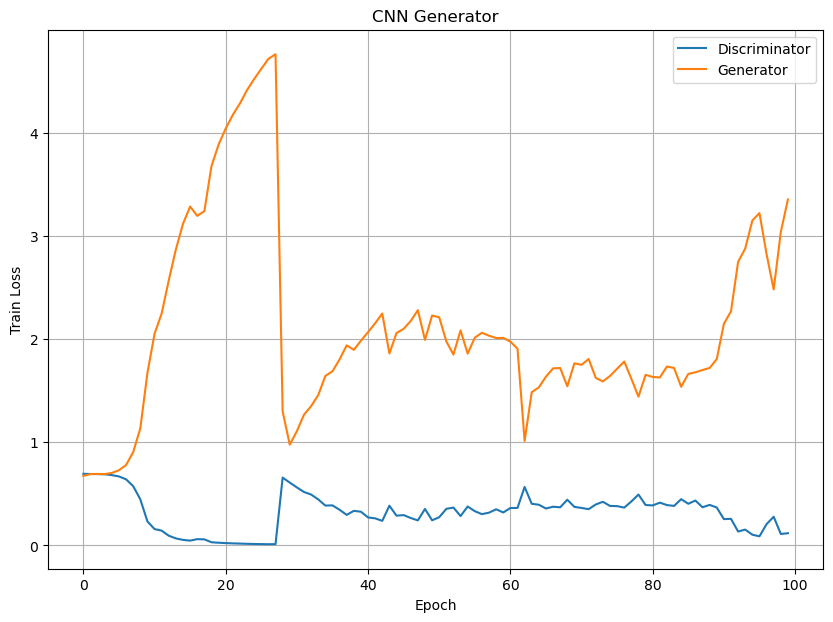

In [11]:
# plt.figure(figsize=(10, 7))
# plt.plot(d_losses_cnn, label='Discriminator')
# plt.plot(g_losses_cnn, label='Generator')
# plt.xlabel('Epoch')
# plt.ylabel('Train Loss')
# plt.title('CNN Generator')
# plt.grid(True)
# plt.legend()
# plt.show()

In [ ]:
# save_model(generator_cnn, "generator_cnn_trained")

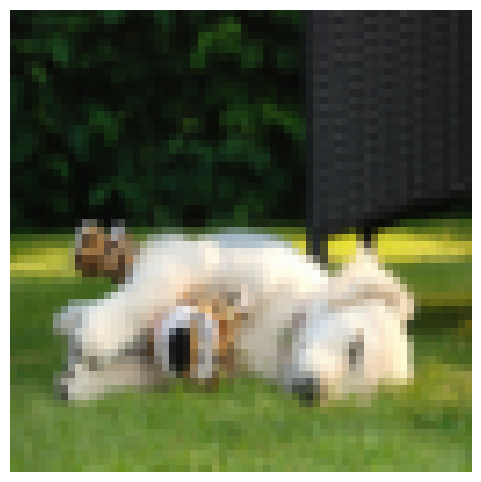

c:\Users\sandr\Desktop\ML\project\image-colorization\utils\plots.py:92: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 12 negative Z values that have been clipped to zero
  rgb_image = lab2rgb(lab_image_reconstructed)


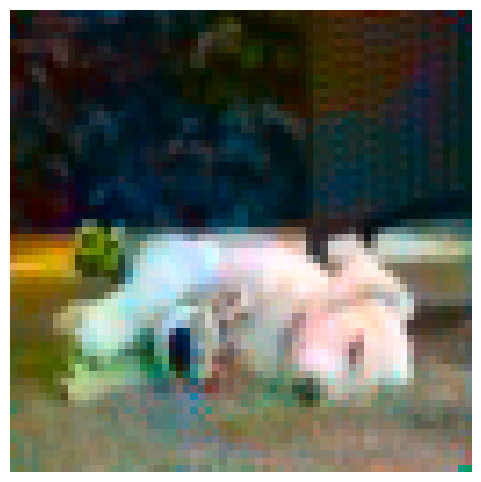

In [46]:
# # check for mode collapse:
# # so whether we get the same colors to different images
# # if so use different loss (wgan)

# input = dataset[5764][1].to(device).unsqueeze(0)
# ab = generator_cnn(input).squeeze(0)
# plot_rgb(dataset[5764][0])
# reconstruct_lab(dataset[5764][1].to(device).detach().cpu(), ab.detach().cpu())

GeneratorCNN model loaded successfully!


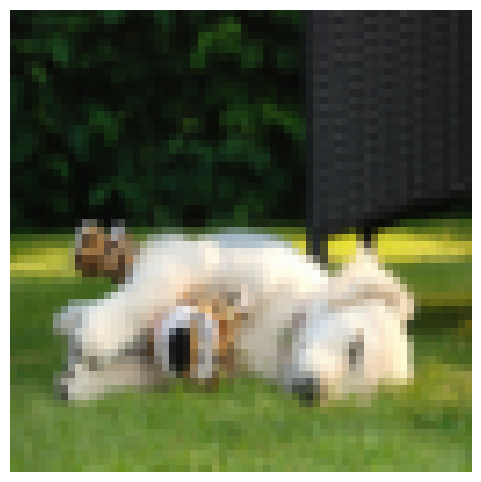

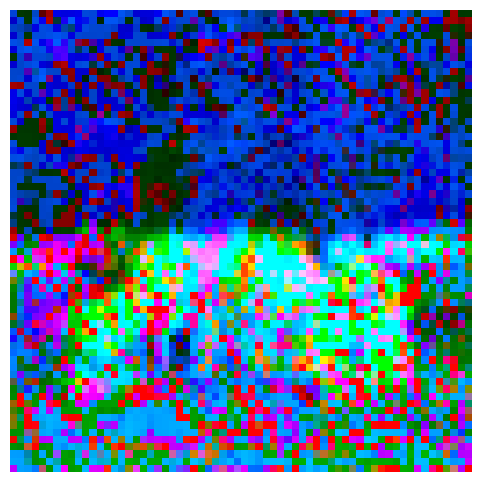

In [48]:
# loaded = load_model(GeneratorCNN(), "models/generator_cnn_epoch26.pth")
# input = dataset[5764][1].unsqueeze(0)
# ab = loaded(input).squeeze(0)
# plot_rgb(dataset[5764][0])
# reconstruct_lab(dataset[5764][1].to(device).detach().cpu(), ab.detach().cpu())